# 📱Adversarial Attacks on SMS Spam Detectors

Exploring how adversarial learning can be used to target SMS spam detectors using Jacobian based Saliency Map attacks.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from gensim.models import Word2Vec

import time

import matplotlib.pyplot  as plt
import seaborn as sns

import numpy  as np
import pandas  as pd
import functools
import pickle

import tensorflow as tf
from tensorflow.python.platform  import  flags
from tensorflow.keras.models import Model

import keras
fromkeras.optimizers  import  RMSprop , Adam
from keras.layers import Input

from cleverhans.attacks  import FastGradientMethod, SaliencyMapMethod
from cleverhans.utils_tf  import  model_train , model_eval , batch_eval, model_argmax
from cleverhans.attacks_tf  import  jacobian_graph
from cleverhans.utils  import  other_classes
from cleverhans.model import Model
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans import initializers
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport

from sklearn.preprocessing import  LabelEncoder , MinMaxScaler
from sklearn.multiclass import  OneVsRestClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier , VotingClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score , roc_curve , auc , f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import  LabelEncoder , MinMaxScaler
from sklearn.svm  import SVC , LinearSVC

stop_words = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packag

In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')

display(df)

,label,sms_text
0,not_spam,"Go until jurong point, crazy.. Available only ..."
1,not_spam,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,not_spam,U dun say so early hor... U c already then say...
4,not_spam,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,not_spam,Will Ì_ b going to esplanade fr home?
5569,not_spam,"Pity, * was in mood for that. So...any other s..."
5570,not_spam,The guy did some bitching but I acted like i'd...


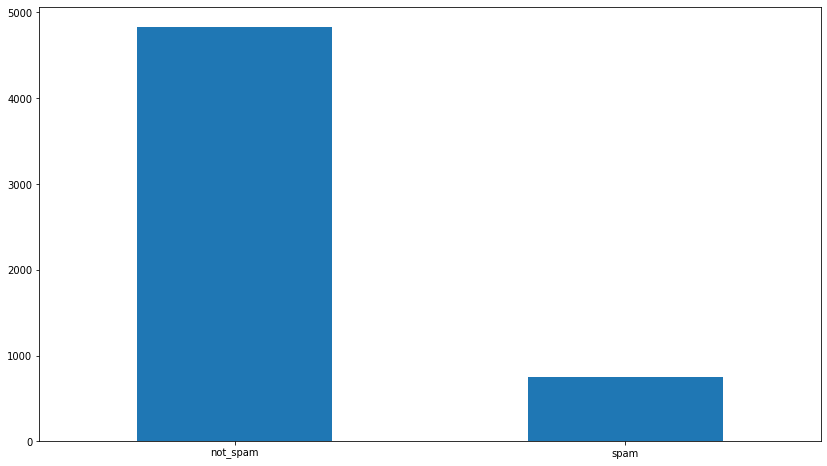

In [3]:
ax = df['label'].value_counts().plot(kind='bar', figsize=(14,8), rot=0)

plt.show()

In [4]:
df['patterns'] = df['sms_text'].apply(lambda x:' '.join(x.lower() for x in x.split()))
df['patterns']= df['patterns'].apply(lambda x: ' '.join(x for x in x.split() if x not in string.punctuation))
df['patterns']= df['patterns'].str.replace('[^\w\s]','')
df['patterns']= df['patterns'].apply(lambda x: ' '.join(x for x in x.split() if  not x.isdigit()))
df['patterns'] = df['patterns'].apply(lambda x:' '.join(x for x in x.split() if not x in stop_words))
df['patterns'] = df['patterns'].apply(lambda x: " ".join([wordnet_lemmatizer.lemmatize(word) for word in x.split()]))
df['patterns'] = df.apply(lambda row: nltk.word_tokenize(row['patterns']), axis=1)

display(df)

,label,sms_text,patterns
0,not_spam,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,not_spam,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,not_spam,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,not_spam,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, go, usf, life, around, though]"
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,"[2nd, time, tried, contact, u, u, å750, pound,..."
5568,not_spam,Will Ì_ b going to esplanade fr home?,"[ì_, b, going, esplanade, fr, home]"
5569,not_spam,"Pity, * was in mood for that. So...any other s...","[pity, mood, soany, suggestion]"
5570,not_spam,The guy did some bitching but I acted like i'd...,"[guy, bitching, acted, like, id, interested, b..."


In [5]:
# Skip-gram model (sg = 1)
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

start_time = time.time()
tokens = pd.Series(df['patterns']).values
# Train the Word2Vec Model
w2v_model = Word2Vec(tokens, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))

word2vec_model_file = 'word2vec_' + str(size) + '.model'
w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 2.8141069412231445


In [6]:
# Load the model from the model file
sg_w2v_model = Word2Vec.load(word2vec_model_file)

# Total number of the words 
print("Total number of words")
print(len(sg_w2v_model.wv.vocab))

Total number of words
8355


In [7]:
# Store the vectors for train data in following file
word2vec_filename = 'all_review_word2vec.csv'

with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in df.iterrows():
        model_vector = (np.mean([sg_w2v_model[token] for token in row['patterns']], axis=0)).tolist()
        
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(size)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
word2vec_df = pd.read_csv(word2vec_filename)
word2vec_df['label'] = df['label']

# Encode labels
word2vec_df = pd.get_dummies(word2vec_df, columns=['label'])

display(word2vec_df.head(10))

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,label_not_spam,label_spam
0,0.023372,-0.037427,0.008116,0.056931,0.006703,-0.013427,0.001595,-0.005466,-0.023632,-0.008749,...,-0.051877,0.026777,0.021287,-0.019306,0.062356,-0.011409,0.052432,0.028585,1,0
1,0.024319,-0.039431,0.008849,0.059525,0.007073,-0.014260,0.001496,-0.005719,-0.025034,-0.009652,...,-0.054451,0.028355,0.021943,-0.019869,0.065198,-0.012004,0.055242,0.029932,1,0
2,0.021218,-0.032655,0.007048,0.051751,0.005403,-0.012245,0.001250,-0.004920,-0.020286,-0.007428,...,-0.046781,0.024672,0.020420,-0.016025,0.056297,-0.009822,0.045647,0.026174,0,1
3,0.032711,-0.053315,0.011733,0.080292,0.009827,-0.019077,0.002291,-0.007563,-0.034054,-0.012980,...,-0.072949,0.037891,0.029556,-0.027185,0.087958,-0.016414,0.074663,0.040000,1,0
4,0.029398,-0.048644,0.010695,0.072748,0.008555,-0.017092,0.002503,-0.007198,-0.030209,-0.011307,...,-0.066557,0.034068,0.027063,-0.024598,0.079587,-0.014613,0.067181,0.036259,1,0
5,0.025790,-0.041052,0.008948,0.063236,0.007305,-0.014954,0.001677,-0.006100,-0.025784,-0.009436,...,-0.057563,0.030006,0.024143,-0.020791,0.068949,-0.012548,0.057374,0.031733,0,1
6,0.024347,-0.039494,0.008245,0.060000,0.006977,-0.014370,0.001826,-0.006155,-0.024922,-0.008931,...,-0.054684,0.028445,0.022546,-0.020031,0.065351,-0.012006,0.055421,0.029972,1,0
7,0.016455,-0.026051,0.005569,0.040624,0.004569,-0.009565,0.001180,-0.004023,-0.016274,-0.006102,...,-0.036754,0.019169,0.015423,-0.013217,0.044119,-0.008176,0.036521,0.020416,1,0
8,0.026137,-0.038017,0.007685,0.063300,0.006560,-0.015521,0.000939,-0.006703,-0.023788,-0.008216,...,-0.057074,0.030661,0.024928,-0.018827,0.068993,-0.010698,0.054951,0.032310,0,1
9,0.035164,-0.053036,0.011201,0.084861,0.008925,-0.020588,0.002484,-0.008507,-0.033766,-0.012141,...,-0.078269,0.041114,0.034934,-0.025879,0.093284,-0.016561,0.075299,0.043700,0,1


In [9]:
headers = list(word2vec_df)
headers.remove('label_not_spam')
headers.remove('label_spam')

X = np.array(word2vec_df[headers].values.tolist())
y = np.array(word2vec_df[['label_not_spam', 'label_spam']].values.tolist())

In [10]:
# Split data to training (70%) and testing (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("Value counts for training \n")
print(y_train[:, 0].size)
print("\n")
print("Value counts for testing \n")
print(y_test[:, 0].size)

Value counts for training 

3900


Value counts for testing 

1672


In [11]:
def classify(X_train, y_train, X_test, y_test):
    # Initialise Decision Tree
    clf = DecisionTreeClassifier()
    # Fit model
    model = clf.fit(X_train, y_train)
    # Predict testing target labels
    prediction = model.predict(X_test)
    
    return prediction

print(classification_report(y_test, classify(X_train, y_train, X_test, y_test)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1454
           1       0.75      0.74      0.74       218

   micro avg       0.93      0.93      0.93      1672
   macro avg       0.85      0.85      0.85      1672
weighted avg       0.93      0.93      0.93      1672
 samples avg       0.93      0.93      0.93      1672



In [12]:
def  mlp_model(input_shape, input_ph=None, logits=False):
    # """145Generate a MultiLayer  Perceptron  model146"""
    model = Sequential()

    layers = [ 
        Dense(256, activation='relu', input_shape=input_shape),
        Dropout(0.4),
        Dense(256,  activation='relu'),
        Dropout(0.4),
        Dense(FLAGS.nb_classes),
    ]
    
    for l in layers:
        model.add(l)
    
    if logits:
        logit_tensor = model(input_ph)

    model.add(Activation("softmax"))

    model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics =['accuracy'])
    model.summary()

    if logits:
        return model, logit_tensor
    return model

In [13]:
def  evaluate():
    """164Model  evaluation  function165"""
    eval_params = {'batch_size': FLAGS.batch_size}
    train_acc = model_eval(sess, x, y, predictions , X_train , y_train , args=eval_params)
    test_acc = model_eval(sess, x, y, predictions , X_test , y_test , args=eval_params)
    print('Train acc: {:.2f} Test  acc: {:.2f} '.format(train_acc, test_acc))

In [14]:
Sequential = keras.models.Sequential
Dense = keras.layers.Dense
Dropout = keras.layers.Dropout
Activation = keras.layers.Activation

plt.style.use('bmh')
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_integer('nb_epochs', 1, 'Number  of  epochs  to train  model') # was 20
flags.DEFINE_integer('batch_size', 256, 'Size of  training  batches ') # was 32
flags.DEFINE_float('learning_rate', 0.1, 'Learning  rate  for  training ')
flags.DEFINE_integer('nb_classes', y_train.shape[1], 'Number  of  classification  classes ')
flags.DEFINE_integer('source_samples', X_train.shape[1], 'Nb of test  set  examples  to  attack ')

FLAGS = flags.FLAGS

# Tensorflow  placeholder  variables
tf.compat.v1.flags.DEFINE_string('f','','')

x = tf.compat.v1.placeholder(tf.float32, shape=(None, X_train.shape[1]))
y = tf.compat.v1.placeholder(tf.float32, shape=(None, FLAGS.nb_classes))
tf.compat.v1.set_random_seed(42)
model = mlp_model((None, X_train.shape[1]))

sess = tf.Session()
keras.backend.set_session(sess)

predictions = model(x)
init = tf.global_variables_initializer()
sess.run(init)

# Train  the  model
train_params = {
    'nb_epochs': FLAGS.nb_epochs,
    'batch_size': FLAGS.batch_size,
    'learning_rate': FLAGS.learning_rate,
    'verbose': 0}

model_train(sess, x, y, predictions, X_train, y_train, evaluate=evaluate, args=train_params)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, None, 256)         256256    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 256)         65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_3 (Dense)              (None, None, 2)           514       
_________________________________________________________________
activation_1 (Activat

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/utils_tf.py:422: UserWarning: This function is deprecated and will be removed on or after 2019-04-05. Switch to cleverhans.train.train.
  warnings.warn("This function is deprecated and will be removed on or after"
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/utils_tf.py:37: UserWarning: This function is deprecated and will be removed on or after 2019-04-05. Switch to cleverhans.train.train.
  warnings.warn("This function is deprecated and will be removed on or after"
[INFO 2020-08-15 16:16:22,697 cleverhans] Epoch 0 took 0.18099689483642578 seconds
[INFO 2020-08-15 16:16:22,795 cleverhans] Completed model training.


Train acc: 0.86 Test  acc: 0.87 


True

In [15]:
# Generate  adversarial  samples  for  all  test  datapoints
source_samples = X_test.shape[0]
# Jacobian -based  Saliency  Map
results = np.zeros((FLAGS.nb_classes, source_samples), dtype ='i')
perturbations = np.zeros((FLAGS.nb_classes, source_samples), dtype ='f')
grads = jacobian_graph(predictions, x, FLAGS.nb_classes)

X_adv = np.zeros((source_samples, X_test.shape[1]))

wrap = KerasModelWrapper(model)

<class 'keras.models.Sequential'>


In [16]:
# Loop over the samples we want to perturb into adversarial examples
samples_to_perturb = np.where(y_test[:,1] == 1)[0] # only malicious
nb_classes = 2 # malicious or benign 

def model_pred(sess, x, predictions, samples):
    feed_dict = {x: samples}
    probabilities = sess.run(predictions, feed_dict)

    print(probabilities, "************")

    if samples.shape[0] == 1:
        return np.argmax(probabilities)
    else:
        return np.argmax(probabilities, axis=1)

In [17]:
def generate_adv_samples(samples_to_perturb, jsma_params):
    adversarial_samples = []
    samples_perturbed_idxs = []

    for i, sample_ind in enumerate(samples_to_perturb):
        sample = X_test[sample_ind: sample_ind+1]

        # We want to find an adversarial example for each possible target class
        # (i.e. all classes that differ from the label given in the dataset)
        current_class = int(np.argmax(y_test[sample_ind]))
        target = 1 - current_class

        # This call runs the Jacobian-based saliency map approach
        one_hot_target = np.zeros((1, nb_classes), dtype=np.float32)
        one_hot_target[0, target] = 1
        jsma_params['y_target'] = one_hot_target

        adv_x = jsma.generate_np(sample, **jsma_params) # adversarial sample generated = adv_x
        adversarial_samples.append(adv_x)
        samples_perturbed_idxs.append(sample_ind)

        # Check if success was achieved
        adv_tgt = np.zeros((1, FLAGS.nb_classes)) # adversarial target = adv_tgt
        adv_tgt[:,target] = 1
        res = int(model_eval(sess, x, y, predictions, adv_x, adv_tgt, args={'batch_size': 1}))

        # Compute number of modified features
        adv_x_reshape = adv_x.reshape(-1)
        test_in_reshape = X_test[sample_ind].reshape(-1)
        nb_changed = np.where(adv_x_reshape != test_in_reshape)[0].shape[0]
        percent_perturb = float(nb_changed) / adv_x.reshape(-1).shape[0]

        # Update the arrays for later analysis
        results[target, sample_ind] = res
        perturbations[target, sample_ind] = percent_perturb

    malicious_targets = np.zeros((len(adversarial_samples), 2))
    malicious_targets[:, 1] = 1

    adversarial_samples = np.stack(adversarial_samples).squeeze()
    original_samples = X_test[np.array(samples_perturbed_idxs)]
    
    return adversarial_samples

In [19]:
gamma = []
theta = []

import itertools

for i in range(1, 10):
    gamma.append(i/10)
    theta.append(i/10)

combinations = list(itertools.product(gamma, theta))

jsma = SaliencyMapMethod(wrap, sess=sess)

final_results = []

for i in combinations:
    jsma_params = {'theta': i[1], 'gamma': i[0], 'clip_min': 0., 'clip_max': 1., 'y_target': None}
    adversarial_samples = generate_adv_samples(samples_to_perturb, jsma_params)
    adv_test = pd.DataFrame(adversarial_samples, columns = headers)

    adv_test['label_not_spam'] = 0
    adv_test['label_spam'] = 1

    test = pd.DataFrame(X_test, columns = headers)
    test['label_not_spam'] = y_test[:, 0]
    test['label_spam'] = y_test[:, 1]

    not_spam = test[test['label_not_spam'] == 1]

    joined = not_spam.append(adv_test, ignore_index=True)

    X_test_adv = np.array(joined[headers])
    y_test_adv = np.array(joined[['label_not_spam', 'label_spam']])
    
    final_results.append(f1_score(y_test, classify(X_train, y_train, X_test_adv, y_test_adv), average='weighted'))

[INFO 2020-08-15 16:16:22,989 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:16:27,508 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:16:32,119 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:16:36,721 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:16:41,285 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:16:45,857 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:16:50,445 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:16:55,080 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:16:59,809 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:17:04,444 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python

[INFO 2020-08-15 16:18:32,830 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:166: UserWarning: Calling generate_np() with multiple different structural parameters is inefficient and should be avoided. Calling generate() is preferred.
  warnings.warn("Calling generate_np() with multiple different "
[INFO 2020-08-15 16:18:38,032 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:166: UserWarning: Calling generate_np() with multiple different structural parameters is inefficient and should be avoided. Calling generate() is preferred.
  warnings.warn("Calling generate_np() with multiple different "
[INFO 2020-08-15 16:18:43,302 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/py

[INFO 2020-08-15 16:20:19,392 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:166: UserWarning: Calling generate_np() with multiple different structural parameters is inefficient and should be avoided. Calling generate() is preferred.
  warnings.warn("Calling generate_np() with multiple different "
[INFO 2020-08-15 16:20:24,940 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:166: UserWarning: Calling generate_np() with multiple different structural parameters is inefficient and should be avoided. Calling generate() is preferred.
  warnings.warn("Calling generate_np() with multiple different "
[INFO 2020-08-15 16:20:30,636 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/py

[INFO 2020-08-15 16:22:16,372 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:166: UserWarning: Calling generate_np() with multiple different structural parameters is inefficient and should be avoided. Calling generate() is preferred.
  warnings.warn("Calling generate_np() with multiple different "
[INFO 2020-08-15 16:22:22,375 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:166: UserWarning: Calling generate_np() with multiple different structural parameters is inefficient and should be avoided. Calling generate() is preferred.
  warnings.warn("Calling generate_np() with multiple different "
[INFO 2020-08-15 16:22:28,383 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/py

In [20]:
results = pd.DataFrame(combinations, columns =['Gamma', 'Theta'])
results['f1_score'] = final_results
display(results)

,Gamma,Theta,f1_score
0,0.1,0.1,0.764993
1,0.1,0.2,0.764259
2,0.1,0.3,0.765459
3,0.1,0.4,0.763892
4,0.1,0.5,0.768033
...,...,...,...
76,0.9,0.5,0.763617
77,0.9,0.6,0.766562
78,0.9,0.7,0.765459
79,0.9,0.8,0.764626


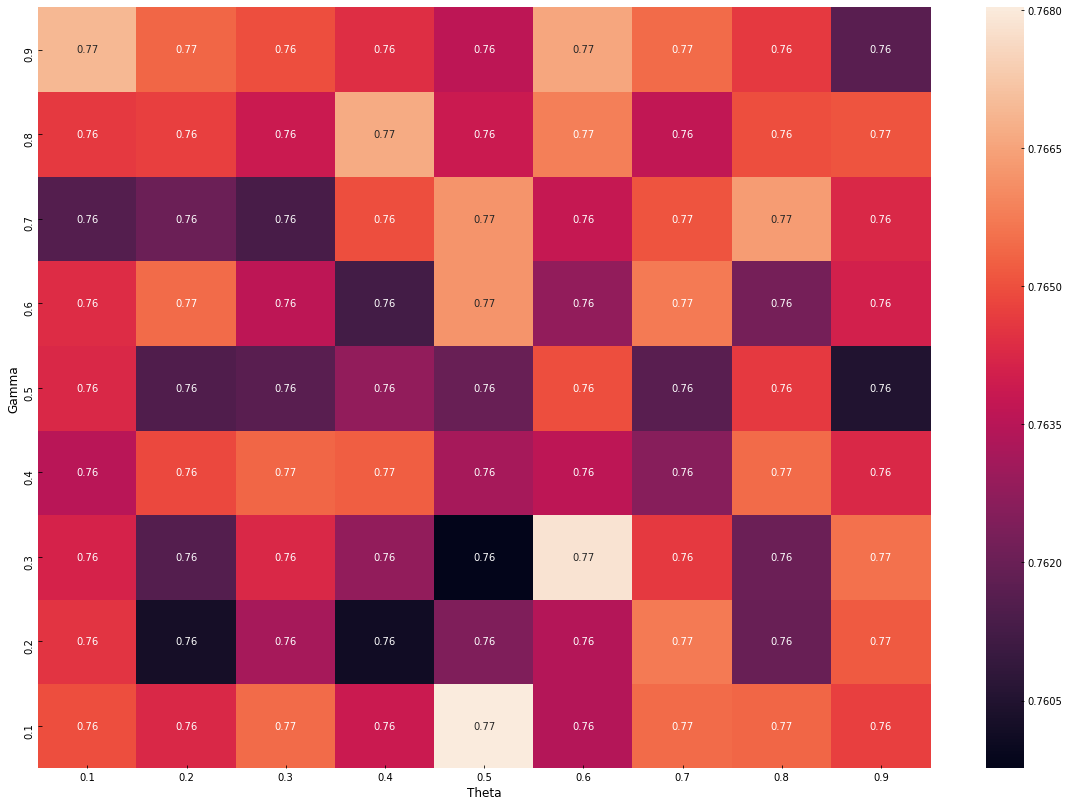

In [21]:
heatmap1_data = pd.pivot_table(results, values='f1_score', index=['Gamma'], columns='Theta')

fig, ax = plt.subplots(figsize=(20,14))
ax = sns.heatmap(heatmap1_data, annot=True, ax=ax)
ax.invert_yaxis()
plt.savefig('heatmap.png')